# **Дипломная работа «Data Science: рекомендательные системы»** (2 часть)

Ишмухаметов Айдар

# Загрузка библиотек

In [94]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных

In [95]:
users = pd.read_csv('/kaggle/input/kion-dataset/users.csv')

В данном файле содержится информация о пользователях:

**user_id** - ID пользователя

**age** - возрастная группа пользователя, строка вида "M_N"
* 18_24 - от 18 до 24 лет включительно
* 25_34 - от 25 до 34 лет включительно
* 35_44 - от 35 до 44 лет включительно
* 45_54 - от 45 до 54 лет включительно
* 55_64 - от 55 до 64 лет включительно
* 65_inf - от 65 и старше

**sex** - пол пользователя
* М - мужчина
* Ж - женщина

**income** - доход пользователя, строка вида "M_N"
* income_0_20
* income_20_40
* income_40_60
* income_60_90  
* income_90_150
* income_150_inf

**kids_flg** - флаг "наличие ребенка"

In [96]:
items = pd.read_csv('/kaggle/input/kion-dataset/items.csv')

**item_id** - ID контента \
**content_type**- Тип контента (фильм, сериал) \
**title** - Название на русском \
**title_orig** - Название оригинальное \
**genres** - Жанры из источника (онлайн-кинотеатры) \
**countries** - страны \
**for_kids** - флаг "контент для детей" \
**age_rating** - возрастной рейтинг \
**studios** - студии \
**directors** - директора \
**actors** - актеры \
**keywords** - ключевые слова \
**description** - описание

In [97]:
interactions = pd.read_csv('/kaggle/input/kion-dataset/interactions.csv')

**user_id** - ID пользователя \
**item_id** - ID контента \
**last_watch_dt** - Дата последнего просмотра \
**total_dur** - Общая продолжительность всех просмотров данного контента в секундах \
**watched_pct** - сколько % фильма просмотрено

# Визуальный анализа данных

## Users/Пользователи

In [98]:
users

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
...,...,...,...,...,...
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


In [7]:
users.isnull().sum()

user_id         0
age         14095
income      14776
sex         13831
kids_flg        0
dtype: int64

Есть пропуски, которые в дальнейшем надо будет обработать.

In [8]:
users.loc[users.age.isna(), 'age'] = 'age_unknown'
users.loc[users.income.isna(), 'income'] = 'income_unknown'
users.loc[users.sex.isna(), 'sex'] = 'sex_unknown'

users.isnull().sum()

user_id     0
age         0
income      0
sex         0
kids_flg    0
dtype: int64

Пропусков больше нет. Также изменим некоторые типы данных (данные будут меньше потреблять оперативной памяти)

In [9]:
users['sex'] = users['sex'].astype('category')
users['age'] = users['age'].astype('category')
users['income'] = users['income'].astype('category')
users['kids_flg'] = users['kids_flg'].astype('bool')

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   user_id   840197 non-null  int64   
 1   age       840197 non-null  category
 2   income    840197 non-null  category
 3   sex       840197 non-null  category
 4   kids_flg  840197 non-null  bool    
dtypes: bool(1), category(3), int64(1)
memory usage: 9.6 MB


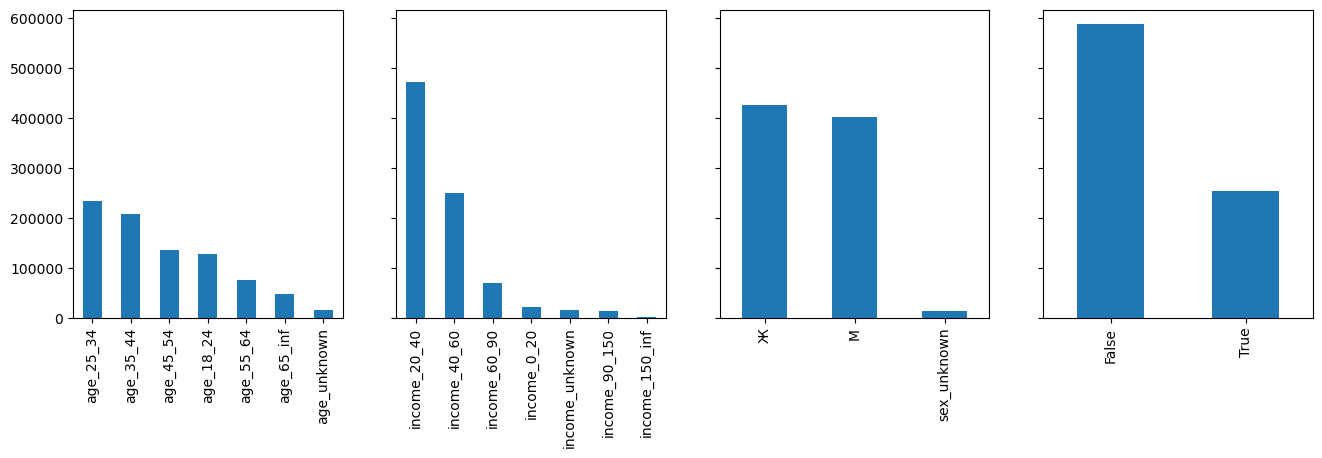

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(16,4))

# кол-во пользователей по возрастным группам
users.age.value_counts().plot.bar(ax=axes[0])

# кол-во пользователей по уровню дохода
users.income.value_counts().plot.bar(ax=axes[1])

# кол-во пользователей по полу
users.sex.value_counts().plot.bar(ax=axes[2])

# кол-во пользователей без детей и с детьми
users.kids_flg.value_counts().plot.bar(ax=axes[3])

plt.show()

Самая многочисленная аудитория в возрастной категории от 25 до 34 лет, самая малочисленная - от 65 лет и старше.

Самая многочисленная аудитория в категории доход от 20 до 40, самая малочисленная - от 150 и более.

Распределение по полу пользователей практически одинаково.

Бездетных пользователей примерно в 2 раза больше чем пользователей с детьми.

Проверим, что id пользователей не задублировались.

In [11]:
users.duplicated(subset=['user_id']).sum()

0

## Items/Контент

In [12]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [13]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


In [14]:
items.nunique()

item_id         15963
content_type        2
title           15293
title_orig      10575
release_year      105
genres           2771
countries         687
for_kids            2
age_rating          6
studios            38
directors        7973
actors          12996
description     15619
keywords        15492
dtype: int64

### content_type

<Axes: >

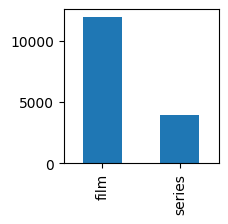

In [ ]:
items.content_type.value_counts().plot.bar(figsize=(2,2))

In [15]:
items.content_type.isna().sum()

0

Основной контент видеосервиса - фильмы. Пропусков нет.

In [16]:
items.content_type = items.content_type.astype('category')

### title,	title_orig

In [17]:
# пропуски?
items.title.isna().sum()

0

In [18]:
# пропуски?
items.title_orig.isna().sum()

4745

Не у всех объектов заполнен признак title_orig, заполним их

In [19]:
items.loc[items.title_orig.isna(), 'title_orig'] = 'None_title_orig'
items.title_orig.isna().sum()

0

Заменим типы данных

In [20]:
items.title = items.title.astype('category')
items.title_orig = items.title_orig.astype('category')

Так как одно и тоже слово может быть написано текстом разного регистра приведем весь текст к нижнему.

In [21]:
items.title = items.title.str.lower()

### release_year

<AxesSubplot:>

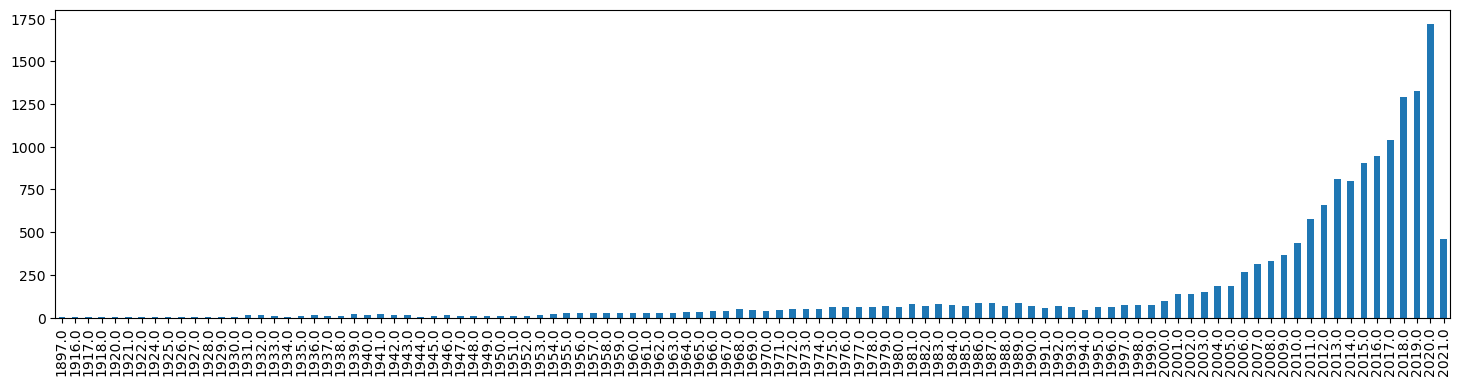

In [22]:
# кол-во контента по годам выпуска
items.release_year.value_counts().sort_index().plot.bar(figsize=(18,4))

С каждым годом видеоконтента снимается все больше.

In [23]:
# есть ли пропуски?
items.release_year.isna().sum()

98

In [24]:
# посмотрим на эти объекты
items[items.release_year.isna()].head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
89,10950,series,начни дома,None_title_orig,NaN,фитнес,Россия,NaN,6.0,NaN,NaN,NaN,Приведи себя в хорошую форму дома с минимальны...,"Начни, дома, Россия, спорт-фитнес, спорт-трене..."
294,3901,series,красота лица,None_title_orig,NaN,фитнес,Россия,NaN,0.0,NaN,NaN,NaN,"Motify научит вас простым, но очень эффективны...","Красота, лица, 2020, Россия, спорт-фитнес, спо..."
374,10656,series,медитации для жизни,None_title_orig,NaN,фитнес,NaN,NaN,6.0,NaN,NaN,NaN,"В этой программе собраны 3 базовых урока, на к...","Медитации, для, жизни, спорт-фитнес, спорт-тре..."
375,11526,series,психология питания,None_title_orig,NaN,"фитнес, спорт",NaN,NaN,6.0,NaN,NaN,NaN,В программе от Motify ты узнаешь о психологиче...,"Психология, питания"
572,11532,series,йога старт,None_title_orig,NaN,фитнес,Россия,NaN,6.0,NaN,NaN,NaN,Программа от Motify подойдет для любого уровня...,"Йога, 2020, Россия, спорт-фитнес, спорт-тренер..."


In [25]:
# заменим
items.loc[items.release_year.isna(), 'release_year'] = 'release_year_unknown'
items.release_year.isna().sum()

0

Как вариант еще можно преобразовать, объединить в десятилетия (1990-1999, 2000-2009, 2010-2019 и 

### genres

In [26]:
items.genres.value_counts()

документальное                                                             816
драмы                                                                      719
комедии                                                                    564
для взрослых                                                               482
русские, мелодрамы                                                         416
                                                                          ... 
драмы, зарубежные, спорт, семейное, комедии                                  1
музыкальные, драмы, зарубежные, семейное, комедии                            1
приключения, полнометражные, зарубежные, семейное, западные мультфильмы      1
детективы, приключения, зарубежные, триллеры, ужасы                          1
фэнтези, семейное, криминал, комедии                                         1
Name: genres, Length: 2771, dtype: int64

In [27]:
# пропуски?
items.genres.isna().sum()

0

In [28]:
# приведем текст к нижнему регистру
items.genres = items.genres.str.lower()

In [29]:
items.genres = items.genres.astype('category')

### countries

<AxesSubplot:>

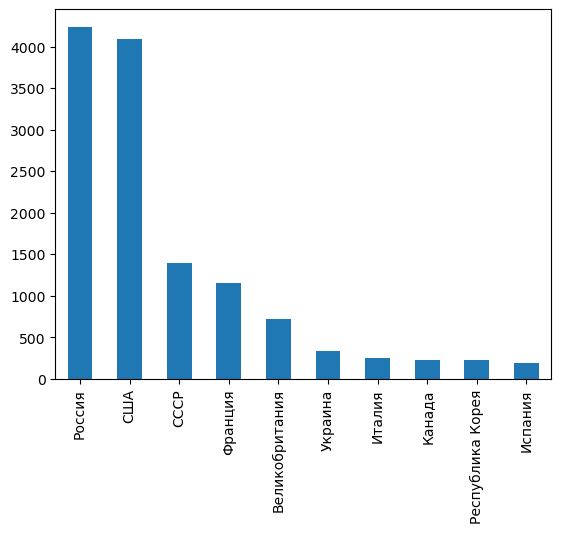

In [30]:
# Top-10 стран по количеству контента в базе
items.countries.value_counts().head(10).plot.bar()

Самые крупные страны-производители фильмов в данном видеосервисе - это Россия и США.

In [31]:
# приведем к нижнему регистру
items.countries = items.countries.str.lower()

In [32]:
# пропуски?
items.countries.isna().sum()

37

In [33]:
items.loc[items.countries.isna(), 'countries'] = 'countries_unknown'
items.countries.isna().sum()

0

In [34]:
items.countries = items.countries.astype('category')

### for_kids

In [35]:
# пропуски
items.for_kids.isna().sum()

15397

Посмотрим какие возрастные катагории обозначены флагом for_kids

In [41]:
items[items.for_kids==1][['for_kids', 'age_rating']].value_counts()

for_kids  age_rating
1.0       0.0           87
          6.0           26
          12.0           1
dtype: int64

In [42]:
items[items.for_kids==0][['for_kids', 'age_rating']].value_counts()

for_kids  age_rating
0.0       16.0          219
          18.0          130
          12.0           89
          6.0            13
          0.0             1
dtype: int64

Было бы логично, что признак установлен для возрастной категории 0+ и 6+. Но есть случаи когда и на 0+ и на 6+ стоит значение 0. \
Очень много пропусков, не будем использовать этот признак.

### age_rating

<AxesSubplot:>

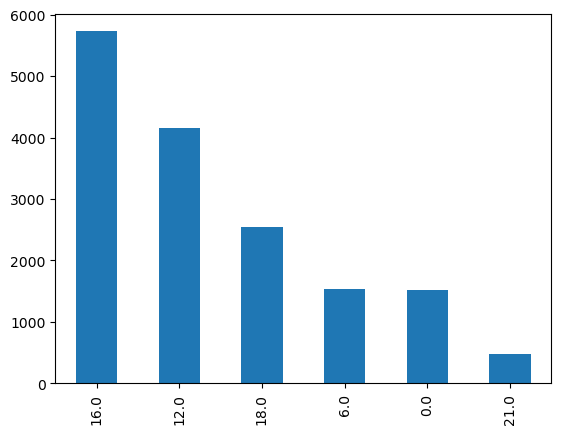

In [49]:
# Кол-во фильмов по рейтингам
items.age_rating.value_counts().plot.bar()

Самый большой выбор контента в категории 16+.

In [50]:
# пропуски?
items.age_rating.isna().sum()

2

Всего два пропуска, посмотрим их.

In [52]:
items[items.age_rating.isna()]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
8297,6316,series,машины-помощники,None_title_orig,2016.0,"русские, для детей, сериалы, хочу всё знать, р...",россия,NaN,NaN,NaN,NaN,NaN,Маленькие мальчики всего мира любят играть в м...,"Машины-помощники, 2017, Россия, работа, преодо..."
12352,14409,series,бибабу,None_title_orig,2017.0,"русские, сериалы, для детей, хочу всё знать, р...",россия,NaN,NaN,NaN,NaN,NaN,В сказочное подводное царство приглашают мален...,"друзья, магия и волшебство, рыбы, моря и океан..."


Это детские мультики 0+

In [53]:
items.loc[items.age_rating.isna(), 'age_rating'] = 0
items.age_rating.isna().sum()

0

Данный признак является числовым, переделаем его в категориальный

In [54]:
items.age_rating = items.age_rating.astype('category')

### studios

<AxesSubplot:>

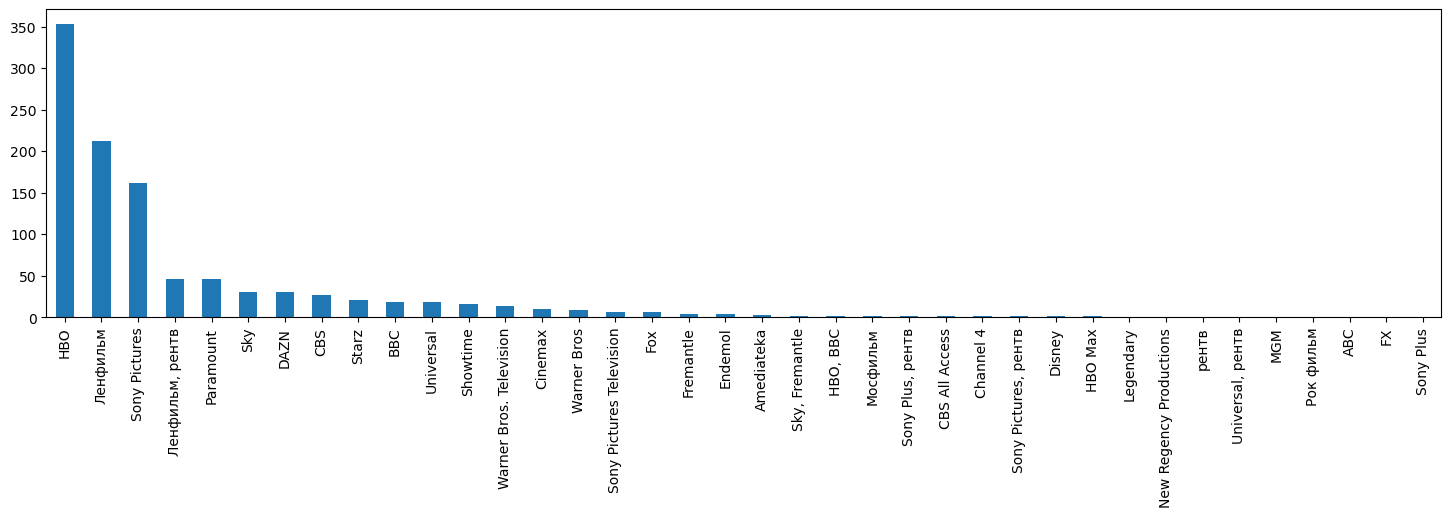

In [55]:
items.studios.value_counts().plot.bar(figsize=(18,4))

Топ-3 - это студии HBO, Ленфильм и Sony Pictures

In [56]:
# пропуски
items.studios.isna().sum()

14898

In [57]:
items.loc[items.studios.isna(), 'studios'] = 'studios_unknown'
items.studios.isna().sum()

0

In [58]:
# приведем к нижнему регистру
items.studios = items.studios.str.lower()

In [59]:
items.studios = items.studios.astype('category')

### directors

In [60]:
items.directors.value_counts()

Оливье Шиабоду                     511
Денис Франческо                     49
Глова Роман Юрьевич                 36
Сергей Зарев                        29
Альфред Хичкок                      28
                                  ... 
Джей Чандрашекхар                    1
Гарт Дженнингс, Кристоф Лурделе      1
Кэри Фукунага                        1
Пол Вейланд                          1
Михаил Миронов                       1
Name: directors, Length: 7973, dtype: int64

In [61]:
items.directors.isna().sum()

1509

In [62]:
items.directors.fillna('directors_unknown', inplace=True)
items.directors.isna().sum()

0

In [63]:
# приведем к нижнему регистру
items.directors = items.directors.str.lower()

In [64]:
items.directors = items.directors.astype('category')

### actors

In [65]:
items.actors.value_counts()

Александр Клюквин                                                                                                                                                              25
Тайлер Никсон, Маркус Лондон, Томми Ганн                                                                                                                                       16
Жан-Пьер Морель, Оливье Шиабоду                                                                                                                                                 8
Кэти Морган                                                                                                                                                                     6
Молли Мэнсон                                                                                                                                                                    6
                                                                                                              

In [66]:
items.actors.isna().sum()

2619

In [67]:
items.actors.fillna('actors_unknown', inplace=True)
items.actors.isna().sum()

0

In [68]:
# приведем к нижнему регистру
items.actors = items.actors.str.lower()

In [69]:
items.actors = items.actors.astype('category')

### description

In [70]:
items.description

0        Мелодрама легендарного Педро Альмодовара «Пого...
1        Уморительная современная комедия на популярную...
2        Профессиональный рестлер Стив Остин («Все или ...
3        Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...
4        Расчетливая чаровница из советского кинохита «...
                               ...                        
15958    Во время погони за браконьерами по лесу, сотру...
15959    Оригинальный киносериал от создателей «Бывших»...
15960    Криминальная драма по мотивам романов о шведск...
15961    Семнадцатилетний Дэмиен мечтает вырваться за п...
15962    Добродушный Гоша не может выйти из дома, чтобы...
Name: description, Length: 15963, dtype: object

In [71]:
items.description.isna().sum()

2

In [72]:
items.description.fillna('None_description', inplace=True)
items.description.isna().sum()

0

### keywords

In [73]:
items.keywords

0        Поговори, ней, 2002, Испания, друзья, любовь, ...
1        Голые, перцы, 2014, США, друзья, свадьбы, прео...
2        Тактическая, сила, 2011, Канада, бандиты, ганг...
3        45, лет, 2015, Великобритания, брак, жизнь, лю...
4        Все, решает, мгновение, 1978, СССР, сильные, ж...
                               ...                        
15958    убийство, вирус, расследование преступления, н...
15959                                Надежда, 2020, Россия
15960                                 Сговор, 2017, Россия
15961                          Среди, камней, 2019, Россия
15962                                   Гоша, 2019, Россия
Name: keywords, Length: 15963, dtype: object

In [75]:
items.keywords.isna().sum()

423

Тут можно попробовать еще вариант - подобрать ключевые слова из description. Пока заполним None

In [76]:
items.keywords.fillna('None_keywords', inplace=True)
items.keywords.isna().sum()

0

### Повторы

Посмотрим, есть ли дубликаты.

In [77]:
# по id фильма
items[items.duplicated(subset=['item_id'],  keep=False)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords


In [78]:
# по нескольким признакам
items[items.duplicated(subset=['content_type', 'countries', 'title', 'directors'],  keep=False)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
7333,13787,film,пираты по соседству,Pirates Down the Street,2020.0,"семейное, приключения",нидерланды,NaN,12.0,studios_unknown,пим ван хёве,"матти стукер, самуэль бо ройрекас, селеста хол...","В скучном городке Линдсборо всё меняется, когд...","2020, нидерланды, пираты, по, соседству"
12757,12889,film,пираты по соседству,De piraten van hiernaast,2020.0,"фильмы, для детей, приключения, зарубежные, се...",нидерланды,NaN,12.0,studios_unknown,пим ван хёве,"берт хана, дэвид люсиер, матти стукер, нинке б...",Самый тихий городок на свете потрясен известие...,"Пираты, по, соседству, 2020, Нидерланды, друзь..."


In [79]:
# удалим обнаруженный дубликат
items.drop_duplicates(subset=['content_type', 'countries', 'title', 'directors'],  inplace=True)
items[items.duplicated(subset=['content_type', 'countries', 'title', 'directors'],  keep=False)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords


### Итог

In [80]:
items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15962 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   item_id       15962 non-null  int64   
 1   content_type  15962 non-null  category
 2   title         15962 non-null  object  
 3   title_orig    15962 non-null  category
 4   release_year  15962 non-null  object  
 5   genres        15962 non-null  category
 6   countries     15962 non-null  category
 7   for_kids      566 non-null    float64 
 8   age_rating    15962 non-null  category
 9   studios       15962 non-null  category
 10  directors     15962 non-null  category
 11  actors        15962 non-null  category
 12  description   15962 non-null  object  
 13  keywords      15962 non-null  object  
dtypes: category(8), float64(1), int64(1), object(4)
memory usage: 2.4+ MB


Пропущенные значения заполнили определнными значениями, при необходимости их можно будет заменить.

## Interactions/Взаимодействия

In [81]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


In [82]:
interactions.isnull().sum()

user_id            0
item_id            0
last_watch_dt      0
total_dur          0
watched_pct      828
dtype: int64

<AxesSubplot:xlabel='watched_pct', ylabel='Count'>

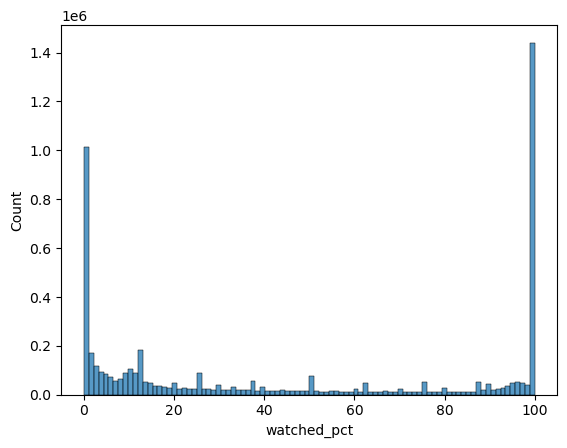

In [83]:
sns.histplot(interactions.watched_pct)

Большая часть досматривает видео до конца. Также очень много тех, кто перестает смотреть сразу же. И, конечно, есть варианты между ними.

In [91]:
# пропуски заменим нулем
interactions.watched_pct.fillna(0, inplace=True)
interactions.watched_pct.isna().sum()

0

Как вариант еще. Пропущенные значения watched_pct можно посчиать, так как известно время просмотра, только для этого нужно откуда-то спарсить общую продолжительность фильма.

### Повторы

In [92]:
# проверка на дубли
interactions.duplicated(subset=['user_id', 'item_id'], keep=False).sum()

0

# Еще немного статистики

В users: пользователи + фичи \
В items: объекты + фичи \
В interactions: пользователи + объекты + взаимодействия 

In [85]:
# пользователи с фичами и взаимодействиями - это пересечение users & interactions
users_features_interactions = (list(set(users.user_id) & set(interactions.user_id.unique())))

# пользователи только с фичами - это users минус interactions
users_only_features = (list(set(users.user_id) - set(interactions.user_id.unique())))

# пользователи только с действиями - это interactions минус users 
users_only_interactions = (list(set(interactions.user_id.unique()) - set(users.user_id)))

# всего пользователей
users_total = users_features_interactions + users_only_features + users_only_interactions

In [86]:
print(f'Кол-во пользователей всего - {len(users_total)}')
print(f'Кол-во пользователей только c фичами - {len(users_only_features)}')
print(f'Кол-во пользователей только c взаимодействиями - {len(users_only_interactions)}')
print(f'Кол-во пользователей c взаимодействиями и фичами - {len(users_features_interactions)}')

Кол-во пользователей всего - 1058088
Кол-во пользователей только c фичами - 95909
Кол-во пользователей только c взаимодействиями - 217891
Кол-во пользователей c взаимодействиями и фичами - 744288


In [87]:
# объекты с фичами и взаимодействиями - это пересечение  items & interactions
items_features_interactions = (list(set(items.item_id) & set(interactions.item_id.unique())))

# объекты только с фичами - это items минус interactions
items_only_features = (list(set(items.item_id) - set(interactions.item_id.unique())))

# объекты только с действиями - это interactions минус items 
items_only_interactions = (list(set(interactions.item_id.unique()) - set(items.item_id)))

# всего пользователей
items_total = items_features_interactions + items_only_features + items_only_interactions

In [88]:
print(f'Кол-во объектов всего - {len(items_total)}')
print(f'Кол-во объектов только c фичами - {len(items_only_features)}')
print(f'Кол-во объектов только c взаимодействиями - {len(items_only_interactions)}')
print(f'Кол-во объектов c взаимодействиями и фичами - {len(items_features_interactions)}')

Кол-во объектов всего - 15963
Кол-во объектов только c фичами - 257
Кол-во объектов только c взаимодействиями - 1
Кол-во объектов c взаимодействиями и фичами - 15705


# Сохранение

Сохраним подготовленные данные

In [93]:
#users.to_csv('users_processed.csv', index=False)
#items.drop(columns=['for_kids']).to_csv('items_processed.csv', index=False)
interactions.to_csv('interactions_processed.csv', index=False)